# IMPORT


In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from os import name
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.manifold import TSNE
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
from qiskit.primitives import Sampler
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torchsummary import summary
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from qiskit import ClassicalRegister
from qiskit.primitives import Sampler
from tqdm import tqdm
import math
from torchvision import datasets
from torchvision import transforms
from qiskit.circuit import  ParameterVector

# UTILITIES

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

   device = torch.device("cpu")

if not torch.cuda.is_available():
    print(f"{color.GREEN}CUDA{color.END} NOT Available")
else:
    print(f"{color.GREEN}CUDA{color.END} Available")
    device = torch.device("cuda")


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
        
else:
    print(f"{color.BLUE}MPS{color.END} Available")
    device = torch.device("mps")

print(f"Using {color.BOLD}{color.PURPLE}{str(device).upper()}{color.END} Acceleration")

CUDA Available
MPS not available because the current PyTorch install was not built with MPS enabled.
Using CUDA Acceleration


In [3]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# MNIST DATASET

In [4]:
NUM_CLASSES = 10
SAMPLER_PER_CLASS = 30
INITIAL_TRAINING_SAMPLES = NUM_CLASSES * SAMPLER_PER_CLASS
LOAD_FASHION = False
RANDOM_STATE = 42

MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])

if LOAD_FASHION:
    MNIST_dataset_train = datasets.FashionMNIST(root="../../data/dataset/FashionMNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.FashionMNIST(root="../../data/dataset/FashionMNIST", train=False, download=True, transform=MNIST_base_transform)
else:
    MNIST_dataset_train = datasets.MNIST(root="../../data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.MNIST(root="../../data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)


index01 = MNIST_dataset_train.targets < NUM_CLASSES
MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

index01_test = MNIST_dataset_test.targets < NUM_CLASSES
MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]



print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=RANDOM_STATE,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")

FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (300, 28, 28)
Total training samples : 300

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



In [5]:
class MNIST_Distance_Dataset_Triplet_Loss(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.kers = np.ones((self.data.shape[0], self.data.shape[0]))
        self.output_transform = transforms.ToTensor()
        self.len = len(self.target)
        self.classes = {i:(np.where(self.target == i)[0], np.where(self.target != i)[0] ) for i in range(10)}


    def __getitem__(self, idx):
        return self.get_anchor(idx), self.get_positive(idx), self.get_negative(idx)
    
    def get_anchor(self, idx):
        return self.output_transform(self.data[idx])
    

    def get_positive(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][0])
        return self.output_transform(self.data[i])
    
    def get_negative(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][1])
        return self.output_transform(self.data[i])


    def get_order(self):
        return self.target.argsort()


    def ordered_pairwise(self):
        return self.kers[:,self.get_order()][self.get_order(),:]


    def get_flatten(self):
        return self.data.reshape((self.data.shape[0], self.data.shape[1]**2))


    def __len__(self):
        return self.len

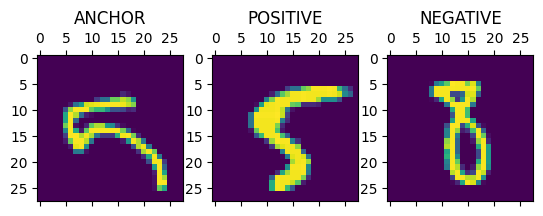

In [6]:
t = MNIST_Distance_Dataset_Triplet_Loss(X, y)

anchor, pos, neg = t[0]
fig, axs = plt.subplots(1,3)

axs[0].set_title("ANCHOR")
axs[0].matshow(anchor.squeeze(0))

axs[1].set_title("POSITIVE")
axs[1].matshow(pos.squeeze(0))

axs[2].set_title("NEGATIVE")
axs[2].matshow(neg.squeeze(0))



# CIRCUITI

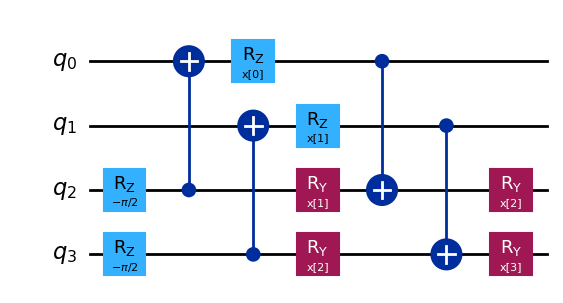

In [7]:
def amplitude_encoding(n_features, param_name):
  qc = RawFeatureVector(n_features)
  qc = qc.assign_parameters(ParameterVector(param_name, n_features))
  qc.name = f"Amplitude Encoding {param_name}"
  return qc


def yz_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  n_qubit = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
  gates = [qc.ry, qc.rz]

  for i in range(n_qubit):
    for gate_i in range(2):
      pindex = i*2 + gate_i
      if pindex < n_features:
        gates[gate_i](params[pindex], i)

  return qc


def y_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  qc = QuantumCircuit(n_features, name=f"Angles Encoding {param_name}")

  for i in range(n_features):
    qc.ry(params[i], i)

  return qc

def pooling_layer(in_lane, param_prefix="pool"):
  qc = QuantumCircuit(in_lane, name="Pooling Layer")
  params = ParameterVector(param_prefix, length=in_lane //2 *3)

  for i in range(in_lane//2):
    current = i
    aux = i+ in_lane//2

    base_param =  current*(in_lane//2 -1)

    qc.rz(-np.pi/2, aux)
    qc.cx(aux, current)
    qc.rz(params[base_param + 0], current)
    qc.ry(params[base_param + 1], aux)
    qc.cx(current, aux)
    qc.ry(params[base_param + 2], aux)

  return qc

display(pooling_layer(4, param_prefix="x").draw(output="mpl"))


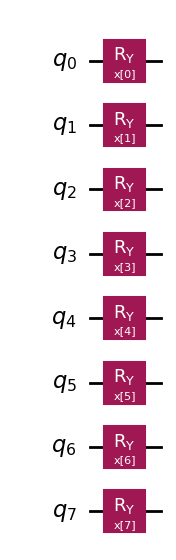

In [8]:
display(y_angles_encoding(8, param_name="x").draw(output="mpl"))

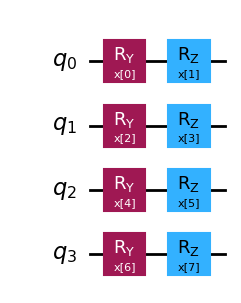

In [9]:
display(yz_angles_encoding(8, param_name="x").draw(output="mpl"))

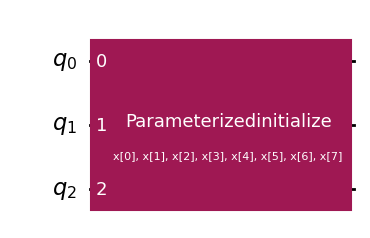

In [10]:
amplitude_encoding(8, param_name="x").draw(output="mpl")

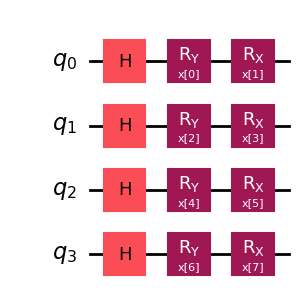

In [11]:
#Modifiche PROF
def hRyRx_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2

  return feature_map

hRyRx_encoding(8).draw(output="mpl")

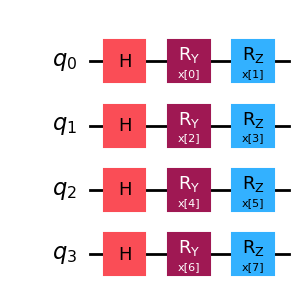

In [12]:
def hRyRz_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rz(input_params[idx+1], i)
      idx +=2
  return feature_map

hRyRz_encoding(8).draw(output="mpl")

# Encoding RyRx

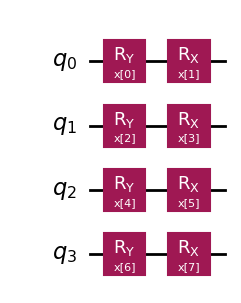

In [61]:
def RyRx_encoding(n_features): 
# qubits
   n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
   # feature extracted from neural network
   n_feature = n_features
   feature_map = QuantumCircuit(n_qubits)
   input_params = ParameterVector(name='x', length=n_feature)
   idx = 0
   for i in range(n_qubits):
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2
   return feature_map

RyRx_encoding(8).draw(output="mpl")

# MODELLO IBRIDO

In [13]:
from abc import ABC, abstractmethod

class QuantumModel(ABC):
    @abstractmethod
    def __init__(self):
        self.encoding = None
        self.ansatz = None
        self.qnn = None
        self.qnn_net = None

    def show(self):
        display(self.qnn.draw(output="mpl"))
        
    def encoding_params(self):
        return self.encoding.parameters
    
    def ansatz_params(self):
        return self.ansatz.parameters

    def circuit(self):
        return self.qnn
    
    def __call__(self):
        return self.qnn_net


# YZ SWAP CIRCUITS

In [14]:
'''
class YZ_Swap(QuantumModel):
    def __init__(self):
        self.encoding = yz_angles_encoding(8, param_name="x")

        pooling1 = pooling_layer(2, "pool1")
        pooling2 = pooling_layer(2, "pool2")

        q1 = QuantumRegister(2 )
        q2 = QuantumRegister(2)
        a = QuantumRegister(1, name="ancilla")
        m = ClassicalRegister(1, name="meas")

        self.ansatz = QuantumCircuit(q1, q2, a, m)
        self.ansatz.barrier()
        self.ansatz = self.ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer1_v1", parameter_prefix="l_v1"))
        self.ansatz = self.ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer1_v2", parameter_prefix="l_v2"), qubits=[2,3])
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(pooling1)
        self.ansatz  = self.ansatz.compose(pooling2, qubits=[2,3])
        self.ansatz.barrier()

        self.ansatz.h(4)
        self.ansatz.cswap(4,3,1)
        self.ansatz.h(4)

        self.ansatz.barrier()
        self.ansatz.measure(a,m)

        self.qnn = QuantumCircuit(q1, q2, a, m).compose(self.encoding).compose(self.ansatz)

        sampler = Sampler(options={
        })

        self.qnn_net = SamplerQNN(
            sampler = sampler,
            circuit=self.qnn,
            input_params=self.encoding.parameters,
            weight_params=self.ansatz.parameters,
            input_gradients=True    
        )


YZ_Swap().show()
'''

'\nclass YZ_Swap(QuantumModel):\n    def __init__(self):\n        self.encoding = yz_angles_encoding(8, param_name="x")\n\n        pooling1 = pooling_layer(2, "pool1")\n        pooling2 = pooling_layer(2, "pool2")\n\n        q1 = QuantumRegister(2 )\n        q2 = QuantumRegister(2)\n        a = QuantumRegister(1, name="ancilla")\n        m = ClassicalRegister(1, name="meas")\n\n        self.ansatz = QuantumCircuit(q1, q2, a, m)\n        self.ansatz.barrier()\n        self.ansatz = self.ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer1_v1", parameter_prefix="l_v1"))\n        self.ansatz = self.ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer1_v2", parameter_prefix="l_v2"), qubits=[2,3])\n        self.ansatz.barrier()\n        self.ansatz  = self.ansatz.compose(pooling1)\n        self.ansatz  = self.ansatz.compose(pooling2, qubits=[2,3])\n        self.ansatz.barrier()\n\n        self.ansatz.h(4)\n        self.ansatz.cswap(4,3,1)\n        self.ansatz.h(4)\n\n

# ZZ SWAP NO LEARN CIRCUIT

In [15]:
'''
class ZZ_Swap_NOLEARN(QuantumModel):
    def __init__(self):
        self.encoding = QuantumCircuit(4)

        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="x"), qubits=[0,1])
        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="y"), qubits=[2,3])

        q1 = QuantumRegister(2, name="v1")
        q2 = QuantumRegister(2, name="v2")
        a = QuantumRegister(1, name="ancilla")
        m = ClassicalRegister(1, name="meas")

        self.ansatz = QuantumCircuit(q1, q2, a, m)
        self.ansatz.barrier()

        self.ansatz.h(4)
        self.ansatz.cswap(4,2,0)
        self.ansatz.cswap(4,3,1)
        self.ansatz.h(4)

        self.ansatz.barrier()
        self.ansatz.measure(a,m)

        self.qnn = QuantumCircuit(q1, q2, a, m).compose(self.encoding).compose(self.ansatz)
        sampler = Sampler(options={
        })

        self.qnn_net = SamplerQNN(
            sampler = sampler,
            circuit=self.qnn,
            input_params=self.encoding.parameters,
            weight_params=self.ansatz.parameters,
            input_gradients=True    
        )


ZZ_Swap_NOLEARN().show()
'''

'\nclass ZZ_Swap_NOLEARN(QuantumModel):\n    def __init__(self):\n        self.encoding = QuantumCircuit(4)\n\n        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="x"), qubits=[0,1])\n        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="y"), qubits=[2,3])\n\n        q1 = QuantumRegister(2, name="v1")\n        q2 = QuantumRegister(2, name="v2")\n        a = QuantumRegister(1, name="ancilla")\n        m = ClassicalRegister(1, name="meas")\n\n        self.ansatz = QuantumCircuit(q1, q2, a, m)\n        self.ansatz.barrier()\n\n        self.ansatz.h(4)\n        self.ansatz.cswap(4,2,0)\n        self.ansatz.cswap(4,3,1)\n        self.ansatz.h(4)\n\n        self.ansatz.barrier()\n        self.ansatz.measure(a,m)\n\n        self.qnn = QuantumCircuit(q1, q2, a, m).compose(self.encoding).compose(self.ansatz)\n        sampler = Sampler(options={\n        })\n\n        self.qnn_net = SamplerQNN(\n            sampler = sampler,\n            circ

# ZZ SWAP CIRCUIT

In [16]:
'''
class ZZ_Swap(QuantumModel):
    def __init__(self):
        self.encoding = QuantumCircuit(4)

        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="x"), qubits=[0,1])
        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="y"), qubits=[2,3])

        q1 = QuantumRegister(2, name="v1")
        q2 = QuantumRegister(2, name="v2")
        a = QuantumRegister(1, name="ancilla")
        m = ClassicalRegister(1, name="meas")

        self.ansatz = QuantumCircuit(q1, q2, a, m)
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l1"), qubits=[0,1])
        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l2"), qubits=[2,3])
        self.ansatz.barrier()
        

        self.ansatz.h(4)
        self.ansatz.cswap(4,2,0)
        self.ansatz.cswap(4,3,1)
        self.ansatz.h(4)

        self.ansatz.barrier()
        self.ansatz.measure(a,m)

        self.qnn = QuantumCircuit(q1, q2, a, m).compose(self.encoding).compose(self.ansatz)

        sampler = Sampler(options={
        })

        self.qnn_net = SamplerQNN(
            sampler = sampler,
            circuit=self.qnn,
            input_params=self.encoding.parameters,
            weight_params=self.ansatz.parameters,
            input_gradients=True    
        )


ZZ_Swap().show()
'''

'\nclass ZZ_Swap(QuantumModel):\n    def __init__(self):\n        self.encoding = QuantumCircuit(4)\n\n        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="x"), qubits=[0,1])\n        self.encoding = self.encoding.compose(ZZFeatureMap(2, parameter_prefix="y"), qubits=[2,3])\n\n        q1 = QuantumRegister(2, name="v1")\n        q2 = QuantumRegister(2, name="v2")\n        a = QuantumRegister(1, name="ancilla")\n        m = ClassicalRegister(1, name="meas")\n\n        self.ansatz = QuantumCircuit(q1, q2, a, m)\n        self.ansatz.barrier()\n        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l1"), qubits=[0,1])\n        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l2"), qubits=[2,3])\n        self.ansatz.barrier()\n        \n\n        self.ansatz.h(4)\n        self.ansatz.cswap(4,2,0)\n        self.ansatz.cswap(4,3,1)\n        self.ansatz.h(4)\n\n        self.ansatz.barrier()\n        self.ansatz.measure(a,m

# YZ RL FULL MEAS (QUELLO USATO NEL FOGLIO EXCELL)

C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\1258489208.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={
C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\1258489208.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  self.qnn_net = SamplerQNN(


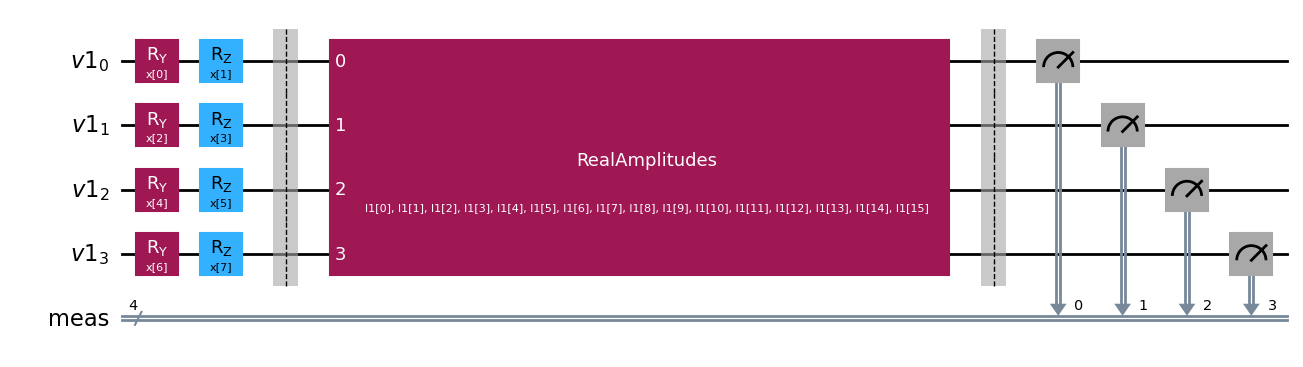

In [122]:
class YZ_RL_FullMeas(QuantumModel):
    def __init__(self):
        self.encoding = yz_angles_encoding(8, param_name="x")
        #self.encoding = hRyRx_encoding(8)
        #self.encoding = hRyRz_encoding(8)
        #self.encoding = RyRx_encoding(8)
  
        self.q1 = QuantumRegister(4, name="v1")

        self.ansatz = QuantumCircuit(self.q1)
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(RealAmplitudes(4, parameter_prefix="l1"))
        self.ansatz.measure_all()

        self.qnn = QuantumCircuit(self.q1).compose(self.encoding).compose(self.ansatz)

        sampler = Sampler(options={
        })

        self.qnn_net = SamplerQNN(
            sampler = sampler,
            circuit=self.qnn,
            input_params=self.encoding.parameters,
            weight_params=self.ansatz.parameters,
            input_gradients=True    
        )


YZ_RL_FullMeas().show()

# YZ QCNN 4

In [18]:
'''
class YZ_QCNN_4(QuantumModel):
    def __init__(self):
        self.encoding = yz_angles_encoding(8, param_name="p")

        self.q1 = QuantumRegister(4, name="v1")
        self.c = ClassicalRegister(2)

        self.ansatz = QuantumCircuit(self.q1, self.c)
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(RealAmplitudes(4, parameter_prefix="l1"))
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(pooling_layer(4, param_prefix="pool"))
        self.ansatz.barrier()
        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l2"), qubits=[2,3])
        self.ansatz.measure(2,0)
        self.ansatz.measure(3,1)

        self.qnn = QuantumCircuit(self.q1).compose(self.encoding).compose(self.ansatz)

        sampler = Sampler(options={
        })

        self.qnn_net = SamplerQNN(
            sampler = sampler,
            circuit=self.qnn,
            input_params=self.encoding.parameters,
            weight_params=self.ansatz.parameters,
            input_gradients=True    
        )


YZ_QCNN_4().show()
'''

'\nclass YZ_QCNN_4(QuantumModel):\n    def __init__(self):\n        self.encoding = yz_angles_encoding(8, param_name="p")\n\n        self.q1 = QuantumRegister(4, name="v1")\n        self.c = ClassicalRegister(2)\n\n        self.ansatz = QuantumCircuit(self.q1, self.c)\n        self.ansatz.barrier()\n        self.ansatz  = self.ansatz.compose(RealAmplitudes(4, parameter_prefix="l1"))\n        self.ansatz.barrier()\n        self.ansatz  = self.ansatz.compose(pooling_layer(4, param_prefix="pool"))\n        self.ansatz.barrier()\n        self.ansatz  = self.ansatz.compose(RealAmplitudes(2, parameter_prefix="l2"), qubits=[2,3])\n        self.ansatz.measure(2,0)\n        self.ansatz.measure(3,1)\n\n        self.qnn = QuantumCircuit(self.q1).compose(self.encoding).compose(self.ansatz)\n\n        sampler = Sampler(options={\n        })\n\n        self.qnn_net = SamplerQNN(\n            sampler = sampler,\n            circuit=self.qnn,\n            input_params=self.encoding.parameters,\n      

# EMBENDING MODEL

In [85]:
class RotationScaler(nn.Module):
    def __init__(self, scale=1):
        super(RotationScaler, self).__init__()

        self.sig = torch.nn.Sigmoid()
        self.scale = scale

    def forward(self, x):
        x = self.sig(x)
        x = x * self.scale
        
        return x
    

class EmbeddingModel(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingModel, self).__init__()

        self.embedding_size = embedding_size
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=embedding_size)
        )

        self.scaler = RotationScaler(scale=2*torch.pi)
        #self.scaler = RotationScaler(scale=torch.pi/2)
    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)
        x = self.reduction(x)
        
        x = self.scaler(x)

        return x



summary(EmbeddingModel(8).to(device if torch.cuda.is_available() else "cpu"), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 8]             968
          Sigmoid-13                    [-1, 8]               0
   RotationScaler-14                   

# QUANTUM EMBEDDER

In [86]:
class QuantumEmbedder(nn.Module):
    def __init__(self, qnn_net):
        super(QuantumEmbedder, self).__init__()
        self.ql = TorchConnector(qnn_net)

        self.embed_adjuster = nn.Sequential(
            nn.Linear(16,16)
        )
    


    def forward(self, anchor):
        return self.embed_adjuster(self.ql(anchor))

qnn_net = YZ_RL_FullMeas()()
embedder= QuantumEmbedder(qnn_net).to(device)(torch.rand((3,8)).to(device))


C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\3841181378.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={
C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\3841181378.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  self.qnn_net = SamplerQNN(


# CLASSICAL EMBEDDER

In [87]:

class ClassicalEmbedder(nn.Module):
    def __init__(self, in_features, out_features):
        super(ClassicalEmbedder, self).__init__()

        self.embed_adjuster = nn.Sequential(
            
            nn.Linear(in_features,out_features),
            nn.Sigmoid(),
            nn.Linear(out_features, out_features)
        )
    
    
    def forward(self, anchor):
        return self.embed_adjuster(anchor)


classical_embedder= ClassicalEmbedder(8,4).to(device)(torch.rand((3,8)).to(device))


# QUANTUM DISTANCE

In [88]:
class QuantumDistance(nn.Module):
    def __init__(self, qnn_net):
        super(QuantumDistance, self).__init__()
        self.ql = TorchConnector(qnn_net)
    
    
    def forward(self, anchor, sample):
        return (self.ql(torch.hstack((anchor, sample)))[:, :1] - 0.5 ) / 0.5





# CLASSICAL DISTANCE

In [89]:
class ClassicalDistance(nn.Module):
    def __init__(self):
        super(ClassicalDistance, self).__init__()
    
    def forward(self, anchor, sample):
        return torch.norm(anchor - sample, dim=1, keepdim=True)



# CLASSICAL LEARNED DISTANCE


In [90]:
class ClassicalLearnedDistance(nn.Module):
    def __init__(self, embedding_size):
        super(ClassicalLearnedDistance, self).__init__()


        self.embedding_size = embedding_size

        self.learner = nn.Sequential(
            nn.Linear(embedding_size * 2, 1)
        )

    def forward(self, anchor, sample):
        return self.learner(torch.hstack((anchor, sample)))



# TRIPLET QUANTUM EMBEDNET

In [91]:
class TripletQuantumEmbedNet(nn.Module):
    def __init__(self, classical_embedding, quantum_embedding, distance):
        super(TripletQuantumEmbedNet, self).__init__()

        self.embedding = classical_embedding
        self.qembed = quantum_embedding
        self.distance = distance

    
    def forward(self, anchor, positive, negative):

        a = self.qembed(self.embedding(anchor))
        p = self.qembed(self.embedding(positive))
        n = self.qembed(self.embedding(negative))

        dp = self.distance(a, p)
        dn = self.distance(a, n)

        return dp, dn
    

# TRIPLET DISTANCE NET 

In [92]:
class TripletDistanceNet(nn.Module):
    def __init__(self, embedding, distance):
        super(TripletDistanceNet, self).__init__()

        self.embedding = embedding
        self.distance = distance

    
    def forward(self, anchor, positive, negative):

        a = self.embedding(anchor)
        p = self.embedding(positive)
        n = self.embedding(negative)

        dp = self.distance(a, p)
        dn = self.distance(a, n)

        return dp, dn
    




# TRIPLET LOSS

In [93]:
class CustomTripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(CustomTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, dist_pos, dist_neg):
        loss = torch.relu(dist_pos - dist_neg + self.margin)
        return loss.mean()

# DEFINIZIONE DISTANCE MODEL

In [94]:
LOAD_MODEL = False


distance_model = TripletQuantumEmbedNet(
    EmbeddingModel(8),
    QuantumEmbedder(YZ_RL_FullMeas()()),
    ClassicalDistance()
    )

#if LOAD_MODEL:
#    with open("C:\\Users\\Utente\\Desktop\\quantum_metric_learning-master\\models\\triplet_loss_swap\\MNIST_QuantumV2_600.pt", "rb") as f:
#        distance_model.load_state_dict(torch.load(f, map_location=device))




training_dataloader = DataLoader(t, batch_size=10, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = CustomTripletLoss(margin=2)
epochs = 200

C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\3841181378.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={
C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\3841181378.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  self.qnn_net = SamplerQNN(


# TRAIN TRIPLET_QUANTUM_EMBEND_NET ( YZ_RL_FULLMEAS )

In [95]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1):

    for epoch in range(epochs):

        prnt = (epoch % print_at) != 0 if epoch!=(epochs-1) else False


        if not(prnt):
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase

        model.train()

        train_loss = 0.0
        train_samples = 0

        

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()



            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)


            if(False):
                a, p, n = model(anchor, positive, negative)
                loss = criterion(a, p, n)
            else:
                e_P, e_N = model(anchor, positive, negative)
                loss = criterion(e_P, e_N)

            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_samples += positive.size(0)


        train_loss /= len(train_data_loader)
        
        if not(prnt):
            print(f"TRAINING   -> Loss: {color.RED}{train_loss:2.6f}{color.END}")
            print("")    

In [96]:
train(
    model=distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=device,
    print_at=10
)

Epoch 1


100%|██████████| 30/30 [01:12<00:00,  2.43s/it]


TRAINING   -> Loss: 1.999369

Epoch 11


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


TRAINING   -> Loss: 1.997353

Epoch 21


100%|██████████| 30/30 [01:14<00:00,  2.50s/it]


TRAINING   -> Loss: 1.993606

Epoch 31


100%|██████████| 30/30 [01:44<00:00,  3.50s/it]


TRAINING   -> Loss: 1.959744

Epoch 41


100%|██████████| 30/30 [01:44<00:00,  3.48s/it]


TRAINING   -> Loss: 1.577985

Epoch 51


100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


TRAINING   -> Loss: 1.174532

Epoch 61


100%|██████████| 30/30 [01:47<00:00,  3.60s/it]


TRAINING   -> Loss: 0.894491

Epoch 71


100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


TRAINING   -> Loss: 0.878544

Epoch 81


100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


TRAINING   -> Loss: 0.667327

Epoch 91


100%|██████████| 30/30 [01:06<00:00,  2.20s/it]


TRAINING   -> Loss: 0.482286

Epoch 100


100%|██████████| 30/30 [01:25<00:00,  2.86s/it]

TRAINING   -> Loss: 0.484694



In [97]:
with open("C:\\Users\\Utente\\Desktop\\quantum_metric_learning-master\\models\\triplet_loss_swap\\MNIST_QuantumV2_RyRx.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

In [123]:

with open("C:\\Users\\Utente\\Desktop\\quantum_metric_learning-master\\models\\triplet_loss_swap\\MNIST_QuantumV2_600.pt", "rb") as f:
        distance_model.load_state_dict(torch.load(f, map_location=device))


C:\Users\Utente\AppData\Local\Temp\ipykernel_3904\3410098929.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distance_model.load_state_dict(torch.load(f, map_location=de

In [127]:
#print the number of epochs used for training in the distance_model.state_dict()
print(distance_model.state_dict().keys())

odict_keys(['embedding.conv_1.0.weight', 'embedding.conv_1.0.bias', 'embedding.conv_2.0.weight', 'embedding.conv_2.0.bias', 'embedding.conv_3.0.weight', 'embedding.conv_3.0.bias', 'embedding.reduction.0.weight', 'embedding.reduction.0.bias', 'embedding.reduction.2.weight', 'embedding.reduction.2.bias', 'qembed.ql.weight', 'qembed.ql._weights', 'qembed.embed_adjuster.0.weight', 'qembed.embed_adjuster.0.bias'])


In [98]:
distance_model.qembed.ql

TorchConnector()

# EVALUATION

In [99]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

cembed = distance_model.embedding
qembed = distance_model.qembed

with torch.no_grad():
    cembed.eval()
    qembed.eval()
    embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(training_dataloader):
        anchor = anchor.to(device)
        embedding_data = np.concatenate((embedding_data, qembed(cembed(anchor)).to("cpu").squeeze(0).numpy()), axis=0)


100%|██████████| 30/30 [00:01<00:00, 29.60it/s]


In [100]:
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.680
Purity:        0.560


In [101]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.689
Purity:        0.607


# TEST EVALUATION

In [118]:
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)

embedder = distance_model.embedding

cembed = distance_model.embedding
qembed = distance_model.qembed

with torch.no_grad():
    cembed.eval()
    qembed.eval()
    test_embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(t_test_loader):
        anchor = anchor.to(device)
        test_embedding_data = np.concatenate((test_embedding_data, qembed(cembed(anchor)).to("cpu").squeeze(0).numpy()), axis=0)


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


In [103]:
print("QUANTUM AGGLOMERATIVE")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)


QUANTUM AGGLOMERATIVE
Silhouette:    0.599
Purity:        0.411


In [119]:
print("QUANTUM KMEANS")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)


QUANTUM KMEANS
Silhouette:    0.615
Purity:        0.448


10000


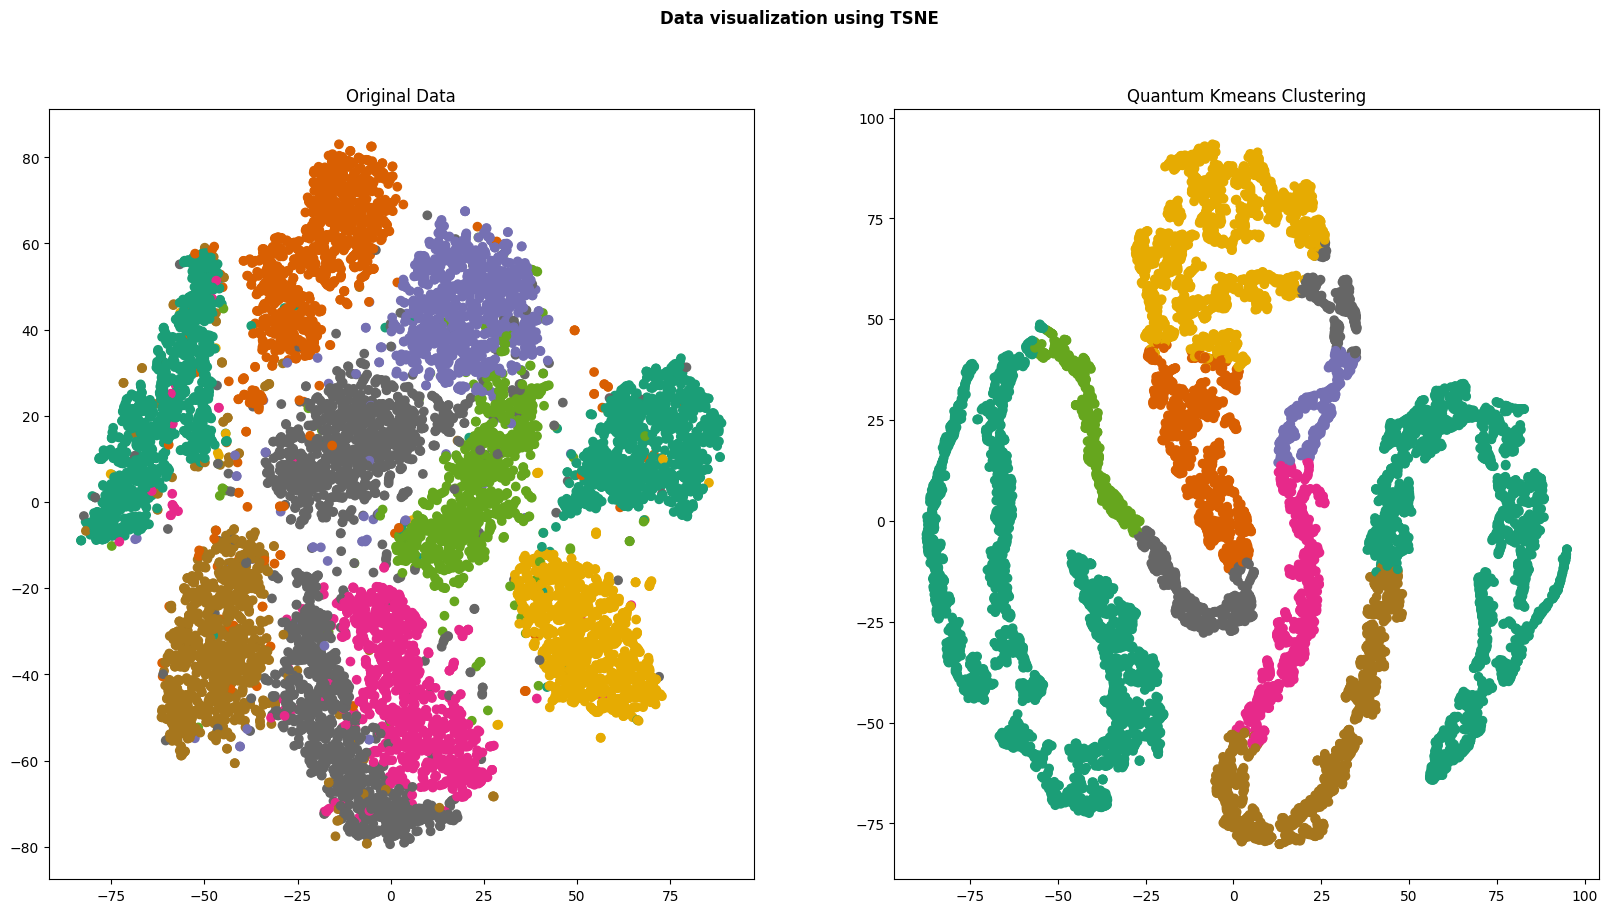

In [121]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=129)

# Get number of samples
n_samples = len(test_embedding_data)
print(n_samples)
# Calculate safe perplexity (typically between 5 and 50).
# If there are fewer than 2 samples, set perplexity to a default value (e.g., 1).
if n_samples < 2:
    perplexity = 1
else:
    perplexity = min(30, n_samples - 1)  # default is 30

# Create TSNE with adjusted perplexity
reduction_model_embedding = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=42
)
vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)

#Visualize the cluserting
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Data visualization using TSNE", weight="bold")
ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target[:len(vis_x)], cmap='Dark2')
ax[0].set_title("Original Data")
ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=quantum_prediction2, cmap='Dark2')
ax[1].set_title("Quantum Kmeans Clustering")
plt.show()